In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, PrecisionRecallDisplay

Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# import file

In [261]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# basic eda

In [262]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [263]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [264]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

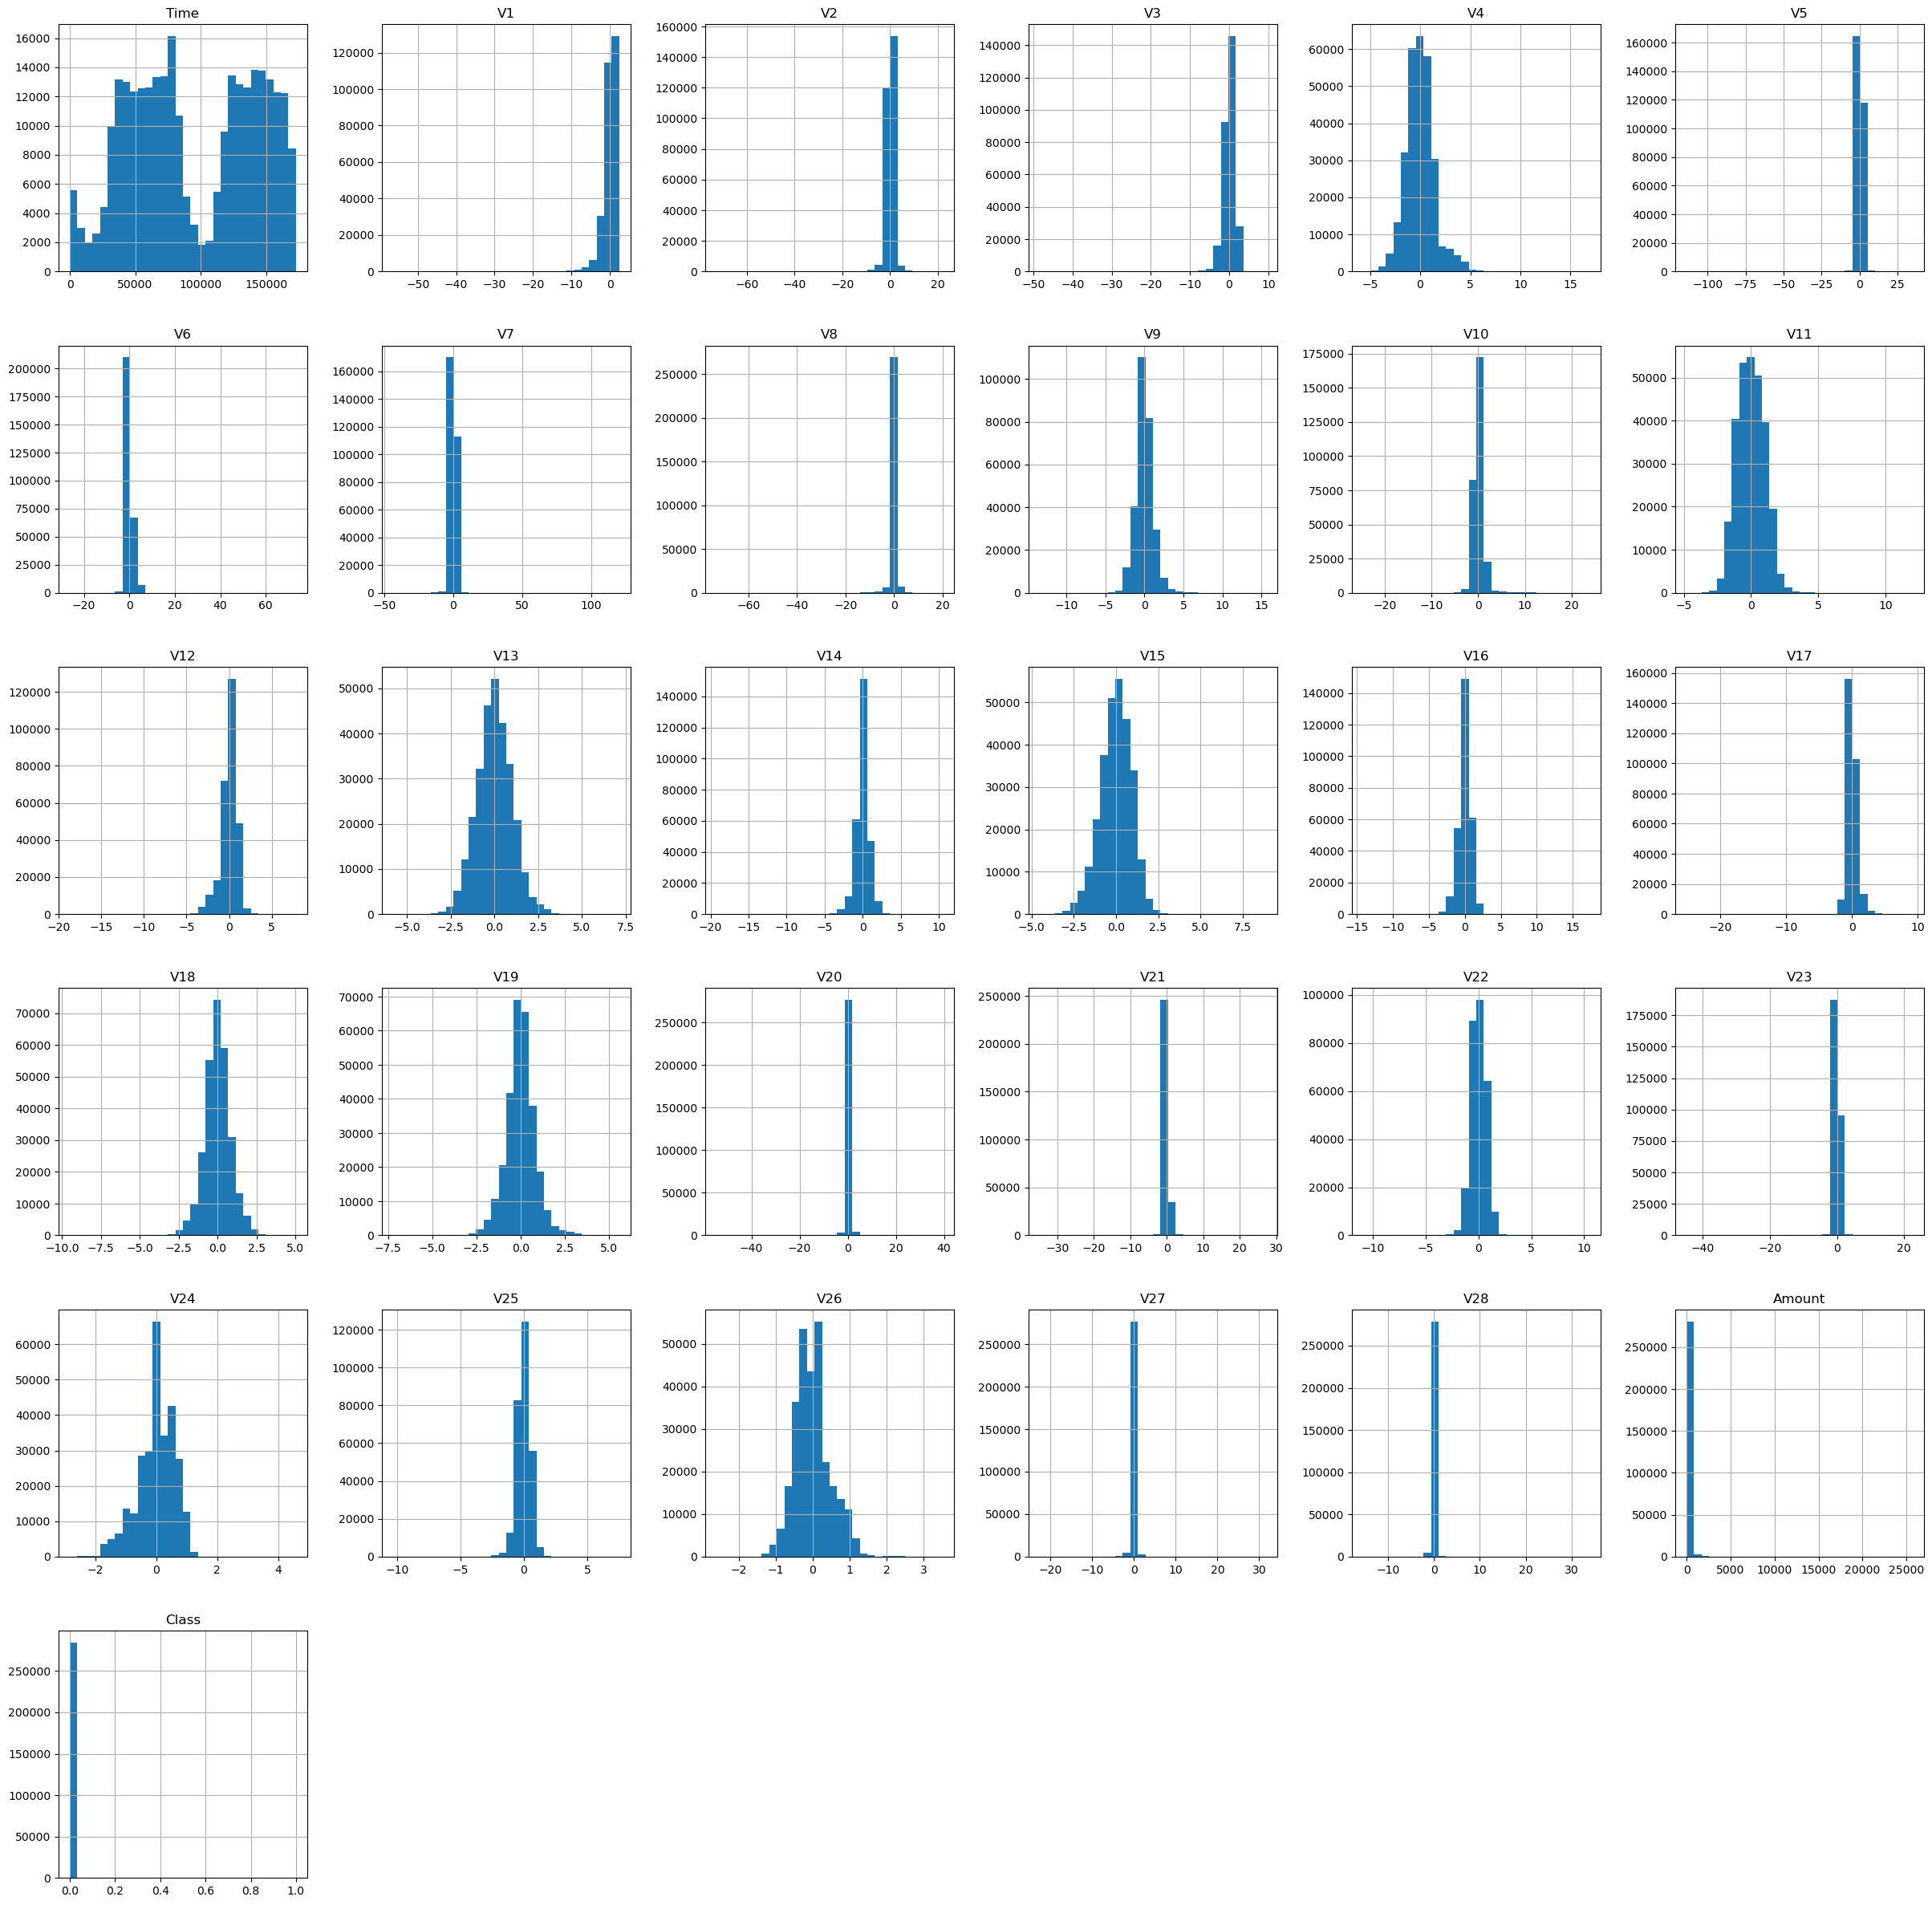

In [265]:
df.hist(bins=30, figsize= (30,30))

In [266]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [267]:
scaler = RobustScaler()
scaler2 = MinMaxScaler()

def scaling(df):
    df['Amount'] = scaler.fit_transform(df['Amount'].to_numpy().reshape(-1,1))
    df['Time'] = scaler2.fit_transform(df['Time'].to_numpy().reshape(-1,1))
    return df

Class
0    284315
1       492
Name: count, dtype: int64


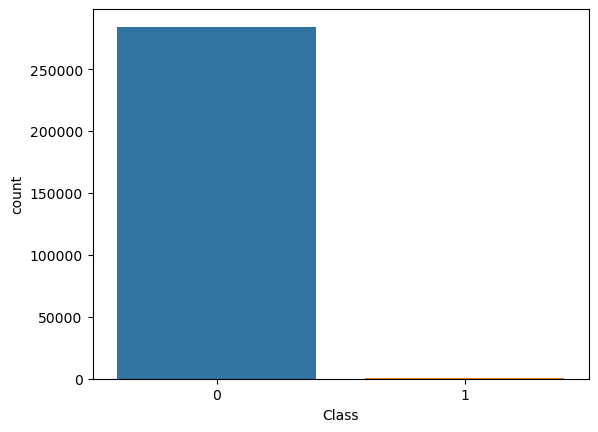

In [268]:
sns.countplot(df, x = 'Class')
print(df['Class'].value_counts())
plt.show()

In [269]:
print(df['Class'].value_counts()[0]/len(df)*100)
print(df['Class'].value_counts()[1]/len(df)*100)

99.82725143693798
0.1727485630620034


<Axes: >

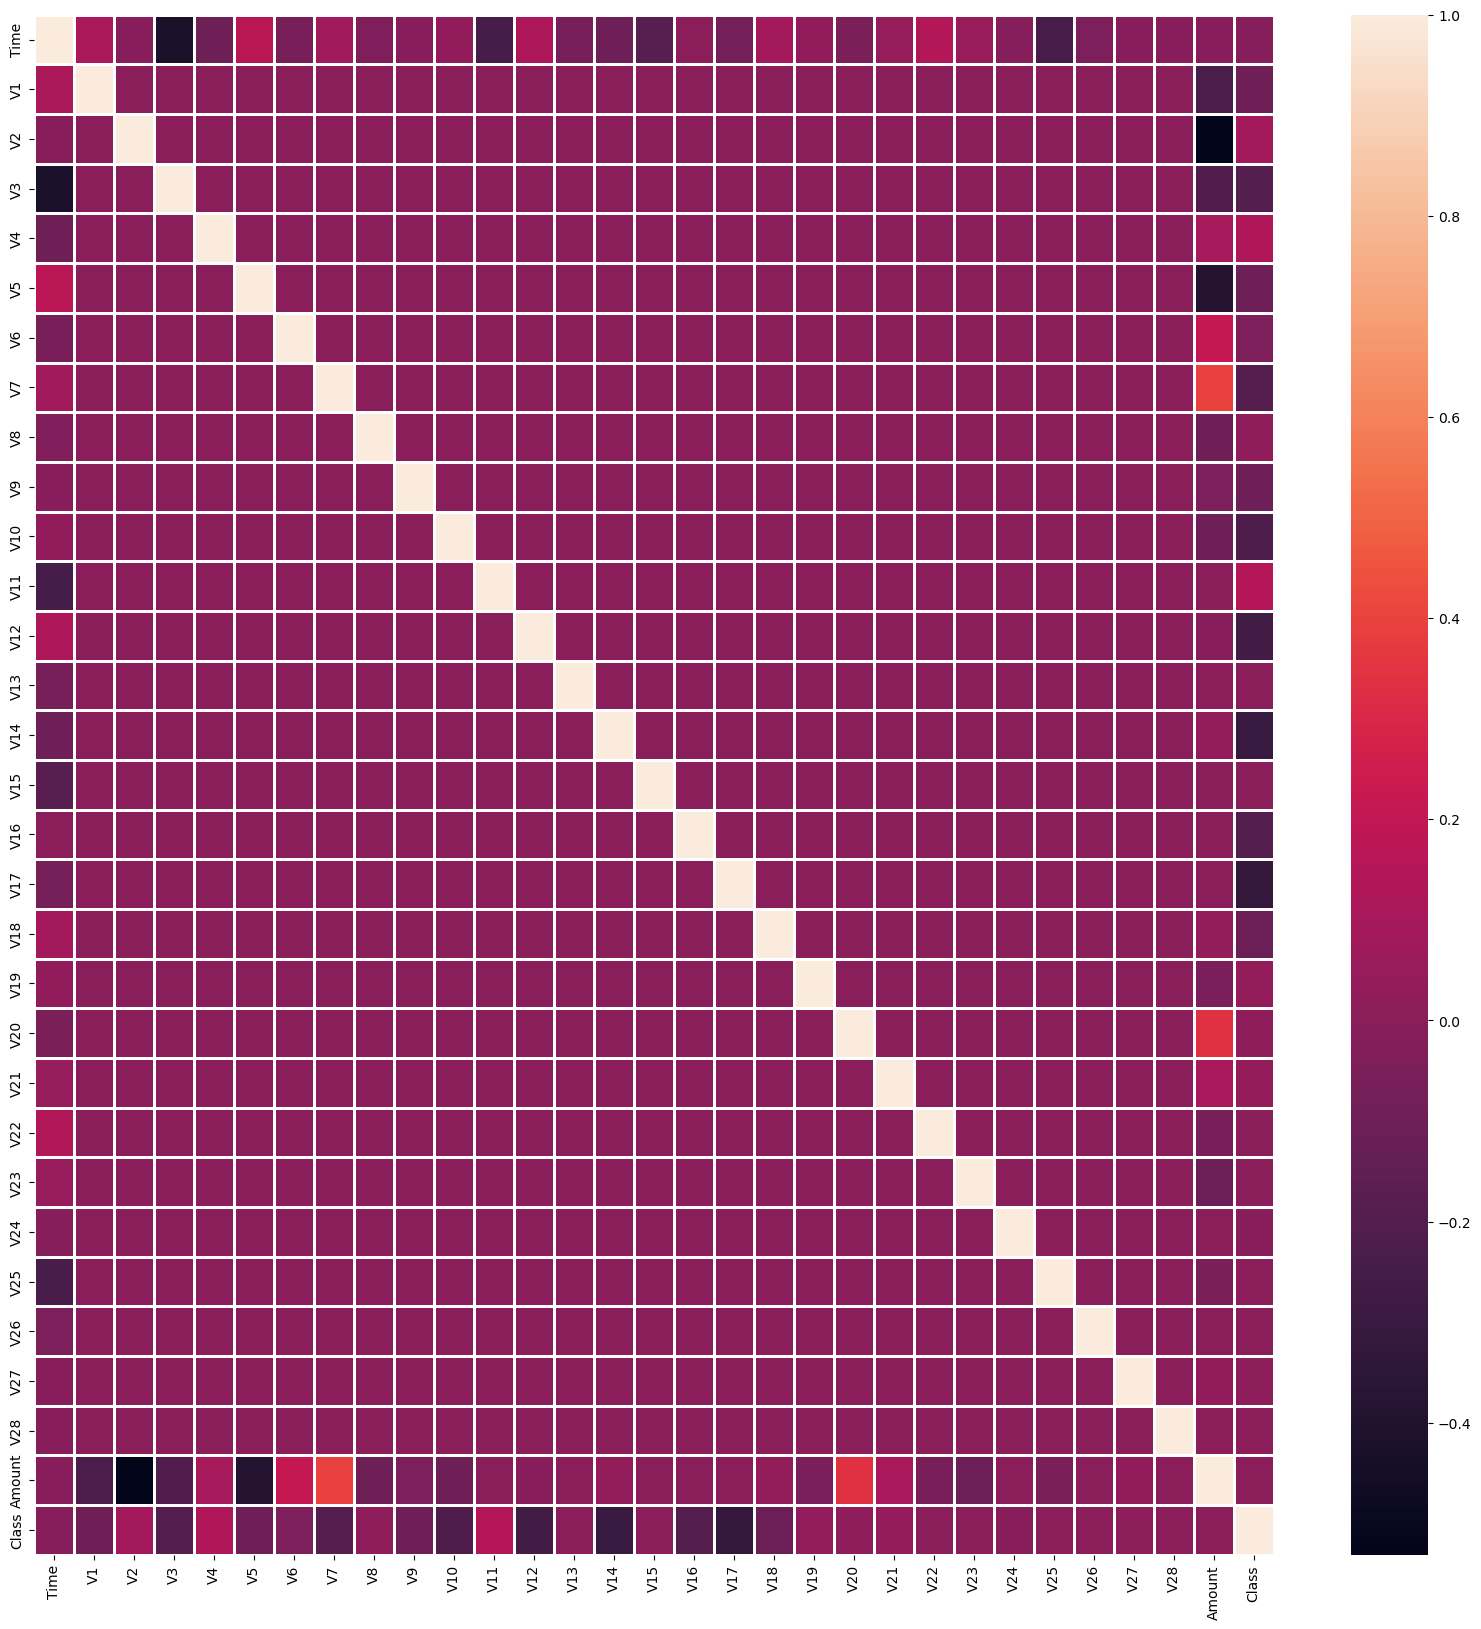

In [270]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), linewidths= 1)

In [271]:
df.corr()['Class']

Time     -0.012323
V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

# predict

1. base model
2. deal with the imbalance dataset (imblearn, smote) (+ parameter tuning)
    - undersampling: remove random record from majority class. good if have a lot of data.  can cause loss of information
    - oversampling: duplicates random record from minority class. good if dont have a lot of data. can cause overfitting and poor generalization
3. dimensionality reduction (correlation, variance, mutual information, rfe)

## 1. base model

In [272]:
from sklearn.model_selection import train_test_split

X , y = df.drop('Class', axis= 1), df['Class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size= 0.3, stratify= y, random_state= 2908)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size= 0.333, stratify= y_temp, random_state= 2908)

In [273]:
print(y_train.value_counts()[1]/len(y_train)*100)
print(y_val.value_counts()[1]/len(y_val)*100)
print(y_test.value_counts()[1]/len(y_val)*100)

0.17254870488152324
0.17371468678715565
0.08597999649061239


In [274]:
X_train = scaling(X_train)
X_val = scaling(X_val)
X_test = scaling(X_test)

In [275]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


lr = LogisticRegression(random_state= 2908)
rf = RandomForestClassifier(random_state= 2908)
xgb = XGBClassifier(random_state = 2908)
lgbm = LGBMClassifier(random_stat = 2908)

clfs = [lr, rf, xgb, lgbm]

In [276]:
def result_clsf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    
    print(clf)
    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_val, y_val_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_val, y_val_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_val, y_val_pred ))
    print(classification_report(y_val, y_val_pred, target_names = ['not fraud', 'fraud']))
    print(confusion_matrix(y_val, y_val_pred))
#     plt.show()

In [277]:
for clf in clfs:
    result_clsf(clf, X_train, y_train, X_val, y_val)

c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2908)
Precision: 0.8235294117647058
Recall: 0.5656565656565656
F1 Score: 0.6706586826347305
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.82      0.57      0.67        99

    accuracy                           1.00     56990
   macro avg       0.91      0.78      0.84     56990
weighted avg       1.00      1.00      1.00     56990

[[56879    12]
 [   43    56]]
RandomForestClassifier(random_state=2908)
Precision: 0.9473684210526315
Recall: 0.7272727272727273
F1 Score: 0.8228571428571427
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     56891
       fraud       0.95      0.73      0.82        99

    accuracy                           1.00     56990
   macro avg       0.97      0.86      0.91     56990
weighted avg       1.00      1.00      1.00     56990

[[56887     4]
 [   27    72]]
XGBClassifier(base_score=None, b

since we want high recall, we continue with xgbclassifier.

## 2. deal with imbalance dataset

### before undersample and oversample

In [278]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [279]:
xgb = XGBClassifier(
    learning_rate = 0.5,
    max_depth = 4,
    # n_estimator = 200,
    early_stopping_rounds=10,
    # eval_metric= roc_curve,
    random_state = 2908)

xgb.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose = 10,)

y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)

[0]	validation_0-logloss:0.31420
[10]	validation_0-logloss:0.00423
[20]	validation_0-logloss:0.00285
[30]	validation_0-logloss:0.00293
[31]	validation_0-logloss:0.00295
Precision: 0.9722222222222222
Recall: 0.7142857142857143
F1 Score: 0.8235294117647058
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.97      0.71      0.82        49

    accuracy                           1.00     28453
   macro avg       0.99      0.86      0.91     28453
weighted avg       1.00      1.00      1.00     28453

[[28403     1]
 [   14    35]]


In [280]:
def plot_roc(model, X_val, y_val):

    y_val_pred_prob = model.predict_proba(X_val)[:,1]

    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob)

    auprc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'Precision-Recall Curve (AUC = {auprc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    # Print the AUPRC
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc:.2f}")


<Figure size 800x600 with 0 Axes>

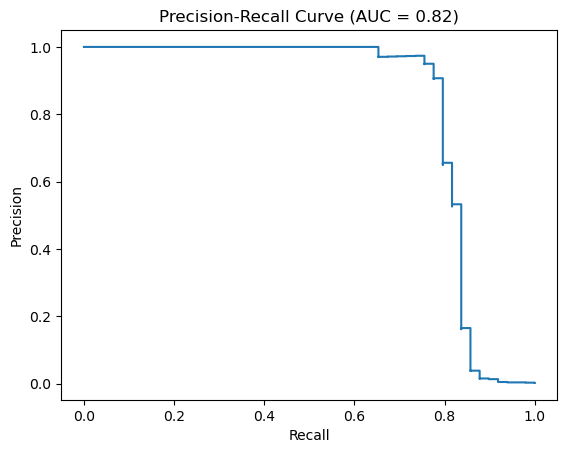

Area Under the Precision-Recall Curve (AUPRC): 0.82


In [281]:
plot_roc(xgb,X_test,y_test)

In [282]:
y_pred_prob = xgb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

In [283]:
res_df = pd.DataFrame({'type': ['original dataset'],
                       'accuracy': accuracy_score(y_test, y_pred),
                       "Precision": precision_score(y_test, y_pred),
                       "Recall": recall_score(y_test, y_pred),
                       'aucpr': auprc,
                       "F1 Score": f1_score(y_test, y_pred)})
res_df

,type,accuracy,Precision,Recall,aucpr,F1 Score
0,original dataset,0.999473,0.972222,0.714286,0.819147,0.823529


### undersampling
even though doing under sampling on train dataset is not recommended since we will be left on 394*2 data points, we will still do it to see it's preformance on the validation dataset

In [284]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [285]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2908)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [286]:
y_under.value_counts()

Class
0    344
1    344
Name: count, dtype: int64

In [287]:
xgb = XGBClassifier(random_state = 2908)
xgb.fit(X_under,y_under)
y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)

Precision: 0.04113614103819784
Recall: 0.8571428571428571
F1 Score: 0.07850467289719626
              precision    recall  f1-score   support

   not fraud       1.00      0.97      0.98     28404
       fraud       0.04      0.86      0.08        49

    accuracy                           0.97     28453
   macro avg       0.52      0.91      0.53     28453
weighted avg       1.00      0.97      0.98     28453

[[27425   979]
 [    7    42]]


In [288]:
# parameters = {
#     'learning_rate': [0.1, 0.5, 0.8],
#     'n_estimators': [200],
#     'max_depth': [3, 4, 5],
# }

# xgb = XGBClassifier(random_state=2908)
# xgb_gs = GridSearchCV(xgb, parameters, cv = kf,scoring='recall', verbose= 3)
# xgb_gs.fit(X_under,y_under)
# print(xgb_gs.best_params_)
# print(xgb_gs.best_score_)

In [289]:
xgb = XGBClassifier(
    learning_rate = 0.5,
    max_depth = 4,
    # n_estimator = 200,
    early_stopping_rounds=10,
    # eval_metric= roc_auc_score,
    random_state = 2908)

xgb.fit(X_under,y_under,eval_set=[(X_val,y_val)],verbose = 10)

y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)


[0]	validation_0-logloss:0.38334
[10]	validation_0-logloss:0.11447
[20]	validation_0-logloss:0.10099
[30]	validation_0-logloss:0.09582
[40]	validation_0-logloss:0.09616
Precision: 0.04065827686350436
Recall: 0.8571428571428571
F1 Score: 0.07763401109057302
              precision    recall  f1-score   support

   not fraud       1.00      0.97      0.98     28404
       fraud       0.04      0.86      0.08        49

    accuracy                           0.96     28453
   macro avg       0.52      0.91      0.53     28453
weighted avg       1.00      0.96      0.98     28453

[[27413   991]
 [    7    42]]


<Figure size 800x600 with 0 Axes>

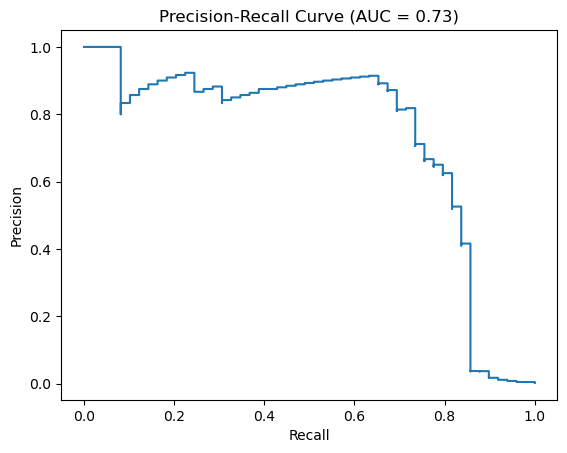

Area Under the Precision-Recall Curve (AUPRC): 0.73


In [290]:
plot_roc(xgb,X_test,y_test)

In [291]:
y_pred_prob = xgb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

In [292]:
new_row = {'type': 'under sampling',
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            'aucpr': auprc,
            "F1 Score": f1_score(y_test, y_pred)}
res_df.loc[len(res_df)] = new_row
res_df

,type,accuracy,Precision,Recall,aucpr,F1 Score
0,original dataset,0.999473,0.972222,0.714286,0.819147,0.823529
1,under sampling,0.964925,0.040658,0.857143,0.730049,0.077634


### oversampling

In [293]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2908)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [294]:
y_over.value_counts()

Class
0    199020
1    199020
Name: count, dtype: int64

In [295]:
xgb = XGBClassifier(random_state = 2908)

xgb.fit(X_over,y_over)
y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)


Precision: 0.9736842105263158
Recall: 0.7551020408163265
F1 Score: 0.8505747126436782
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.97      0.76      0.85        49

    accuracy                           1.00     28453
   macro avg       0.99      0.88      0.93     28453
weighted avg       1.00      1.00      1.00     28453

[[28403     1]
 [   12    37]]


In [296]:
# parameters = {
#     'learning_rate': [0.1, 0.5, 0.8],
#     # 'n_estimators': [200],
#     'max_depth': [3, 4, 5],
# }

# xgb = XGBClassifier(random_state=2908)
# xgb_gs = GridSearchCV(xgb, parameters, cv = kf,scoring='accuracy', verbose= 3)
# xgb_gs.fit(X_over,y_over)
# print(xgb_gs.best_params_)
# print(xgb_gs.best_score_)

In [297]:
xgb = XGBClassifier(
    learning_rate = 0.5,
    max_depth = 4,
    # n_estimator = 200,
    early_stopping_rounds=10,
    # eval_metric= roc_auc_score,
    random_state = 2908)

xgb.fit(X_over,y_over,eval_set=[(X_val,y_val)],verbose = 10)

y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)


[0]	validation_0-logloss:0.36664
[10]	validation_0-logloss:0.03895
[20]	validation_0-logloss:0.01322
[30]	validation_0-logloss:0.00552
[40]	validation_0-logloss:0.00383
[50]	validation_0-logloss:0.00338
[60]	validation_0-logloss:0.00323
[70]	validation_0-logloss:0.00328
[72]	validation_0-logloss:0.00332
Precision: 0.975
Recall: 0.7959183673469388
F1 Score: 0.8764044943820225
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.97      0.80      0.88        49

    accuracy                           1.00     28453
   macro avg       0.99      0.90      0.94     28453
weighted avg       1.00      1.00      1.00     28453

[[28403     1]
 [   10    39]]


<Figure size 800x600 with 0 Axes>

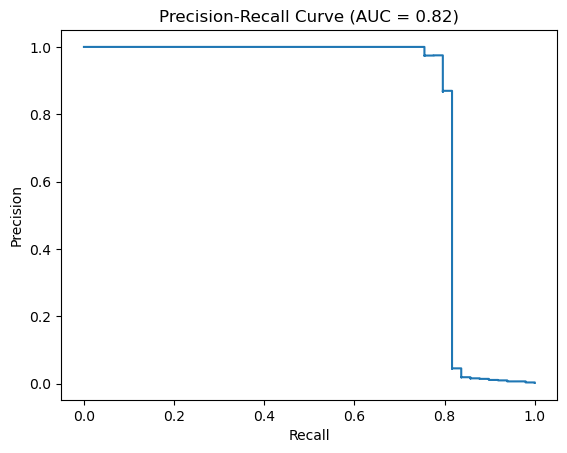

Area Under the Precision-Recall Curve (AUPRC): 0.82


In [298]:
plot_roc(xgb,X_test,y_test)

In [299]:
y_pred_prob = xgb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

In [300]:
new_row = {'type': 'over sampling',
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            'aucpr': auprc,
            "F1 Score": f1_score(y_test, y_pred)}
res_df.loc[len(res_df)] = new_row
res_df

,type,accuracy,Precision,Recall,aucpr,F1 Score
0,original dataset,0.999473,0.972222,0.714286,0.819147,0.823529
1,under sampling,0.964925,0.040658,0.857143,0.730049,0.077634
2,over sampling,0.999613,0.975000,0.795918,0.815177,0.876404


### oversampling using smote

In [301]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2908)
X_smt, y_smt = sm.fit_resample(X_train, y_train)

In [302]:
y_smt.value_counts()

Class
0    199020
1    199020
Name: count, dtype: int64

In [303]:
xgb = XGBClassifier(random_state = 2908)

xgb.fit(X_smt,y_smt)
y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)


Precision: 0.7692307692307693
Recall: 0.8163265306122449
F1 Score: 0.7920792079207921
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.77      0.82      0.79        49

    accuracy                           1.00     28453
   macro avg       0.88      0.91      0.90     28453
weighted avg       1.00      1.00      1.00     28453

[[28392    12]
 [    9    40]]


In [304]:
# parameters = {
#     'learning_rate': [0.1, 0.5, 0.8],
#     'n_estimators': [200],
#     'max_depth': [3, 4, 5],
# }

# xgb = XGBClassifier(random_state=2908)
# xgb_gs = GridSearchCV(xgb, parameters, cv = kf,scoring='recall', verbose= 3)
# xgb_gs.fit(X_smt,y_smt)
# print(xgb_gs.best_params_)
# print(xgb_gs.best_score_)

In [305]:
xgb = XGBClassifier(
    learning_rate = 0.5,
    max_depth =4,
    # n_estimator = 200,
    early_stopping_rounds=10,
    # eval_metric= roc_auc_score,
    random_state = 2908)

xgb.fit(X_smt,y_smt,eval_set=[(X_val,y_val)],verbose = 10)
y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)


[0]	validation_0-logloss:0.36937
[10]	validation_0-logloss:0.06196
[20]	validation_0-logloss:0.03286
[30]	validation_0-logloss:0.01900
[40]	validation_0-logloss:0.01318
[50]	validation_0-logloss:0.00954
[60]	validation_0-logloss:0.00713
[70]	validation_0-logloss:0.00591
[80]	validation_0-logloss:0.00509
[90]	validation_0-logloss:0.00477
[99]	validation_0-logloss:0.00461
Precision: 0.5633802816901409
Recall: 0.8163265306122449
F1 Score: 0.6666666666666666
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.56      0.82      0.67        49

    accuracy                           1.00     28453
   macro avg       0.78      0.91      0.83     28453
weighted avg       1.00      1.00      1.00     28453

[[28373    31]
 [    9    40]]


<Figure size 800x600 with 0 Axes>

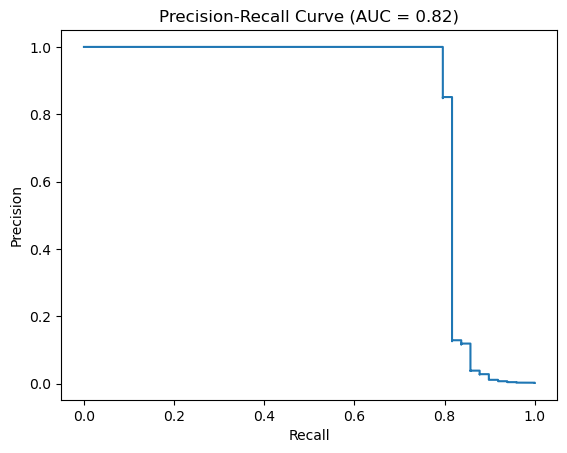

Area Under the Precision-Recall Curve (AUPRC): 0.82


In [306]:
plot_roc(xgb,X_test,y_test)

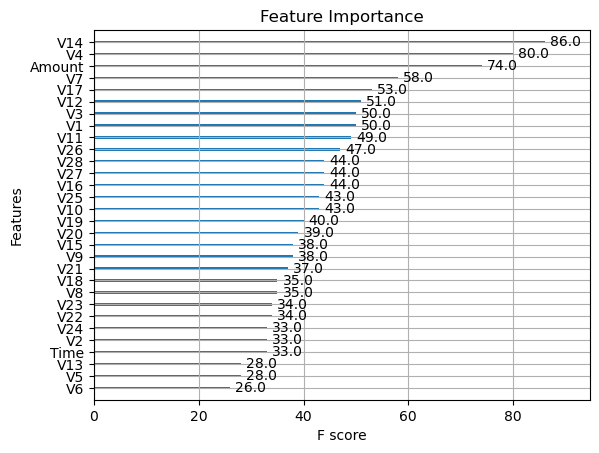

In [307]:
import xgboost
xgboost.plot_importance(xgb)
plt.title('Feature Importance')
plt.show()

In [308]:
y_pred_prob = xgb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

In [309]:
new_row = {'type': 'smote',
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            'aucpr': auprc,
            "F1 Score": f1_score(y_test, y_pred)}
res_df.loc[len(res_df)] = new_row
res_df

,type,accuracy,Precision,Recall,aucpr,F1 Score
0,original dataset,0.999473,0.972222,0.714286,0.819147,0.823529
1,under sampling,0.964925,0.040658,0.857143,0.730049,0.077634
2,over sampling,0.999613,0.975000,0.795918,0.815177,0.876404
3,smote,0.998594,0.563380,0.816327,0.820114,0.666667


### smotenn
combination of under and over sampling using smotenn. the advantage is smotenn generates less noisy samples compare to smote since smote is interpolating new points betweet marginal outliers and inliers

In [310]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=2908)
X_smtnn, y_smtnn = smote_enn.fit_resample(X_train, y_train)

In [311]:
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

In [312]:
y_smtnn.value_counts()

Class
1    199020
0    198637
Name: count, dtype: int64

In [313]:
xgb = XGBClassifier(random_state = 2908)

xgb.fit(X_smtnn, y_smtnn)
y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)

Precision: 0.7272727272727273
Recall: 0.8163265306122449
F1 Score: 0.7692307692307693
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.73      0.82      0.77        49

    accuracy                           1.00     28453
   macro avg       0.86      0.91      0.88     28453
weighted avg       1.00      1.00      1.00     28453



In [314]:
# parameters = {
#     'learning_rate': [0.5],
#     'n_estimators': [200],
#     'max_depth': [5,8,10],
# }

# xgb = XGBClassifier(random_state=2908)
# xgb_gs = GridSearchCV(xgb, parameters, cv = kf,scoring='recall', verbose= 3)
# xgb_gs.fit(X_smtnn, y_smtnn)
# print(xgb_gs.best_params_)
# print(xgb_gs.best_score_)

In [315]:
xgb = XGBClassifier(
    learning_rate = 0.5,
    max_depth = 4,
    # n_estimator = 200,
    early_stopping_rounds=10,
    # eval_metric= roc_auc_score,
    random_state = 2908)

xgb.fit(X_smtnn, y_smtnn,eval_set=[(X_val,y_val)],verbose = 10)

y_pred = xgb.predict(X_test)

# Precision: TP/(TP+FP)
print("Precision:", precision_score(y_test, y_pred))
# Recall: TP/(TP+FN)
print("Recall:", recall_score(y_test, y_pred))
# F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
cfs_mat = confusion_matrix(y_test, y_pred)
print(cfs_mat)

[0]	validation_0-logloss:0.36959
[10]	validation_0-logloss:0.06342
[20]	validation_0-logloss:0.03605
[30]	validation_0-logloss:0.02086
[40]	validation_0-logloss:0.01449
[50]	validation_0-logloss:0.01062
[60]	validation_0-logloss:0.00846
[70]	validation_0-logloss:0.00739
[80]	validation_0-logloss:0.00677
[90]	validation_0-logloss:0.00638
[99]	validation_0-logloss:0.00620
Precision: 0.5342465753424658
Recall: 0.7959183673469388
F1 Score: 0.6393442622950819
              precision    recall  f1-score   support

   not fraud       1.00      1.00      1.00     28404
       fraud       0.53      0.80      0.64        49

    accuracy                           1.00     28453
   macro avg       0.77      0.90      0.82     28453
weighted avg       1.00      1.00      1.00     28453

[[28370    34]
 [   10    39]]


<Figure size 800x600 with 0 Axes>

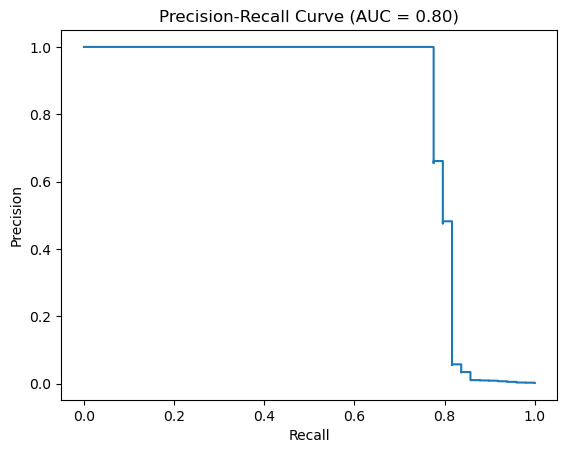

Area Under the Precision-Recall Curve (AUPRC): 0.80


In [316]:
plot_roc(xgb,X_test,y_test)

In [317]:
y_pred_prob = xgb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auprc = auc(recall, precision)

In [318]:
new_row = {'type': 'smotenn',
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            'aucpr': auprc,
            "F1 Score": f1_score(y_test, y_pred)}
res_df.loc[len(res_df)] = new_row
res_df

,type,accuracy,Precision,Recall,aucpr,F1 Score
0,original dataset,0.999473,0.972222,0.714286,0.819147,0.823529
1,under sampling,0.964925,0.040658,0.857143,0.730049,0.077634
2,over sampling,0.999613,0.975000,0.795918,0.815177,0.876404
3,smote,0.998594,0.563380,0.816327,0.820114,0.666667
4,smotenn,0.998454,0.534247,0.795918,0.801443,0.639344


from the result table above, by comparing the recall, precision, and F1 score, we are pretty happy with the result of oversampling using smote. 

## 3. dimensionality reduction

## correlation

<Axes: >

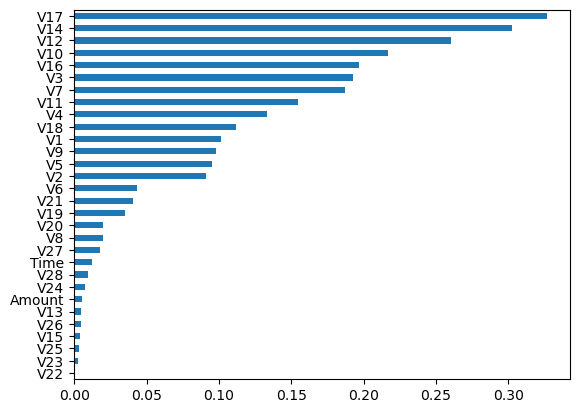

In [319]:
df.corr().drop('Class')['Class'].abs().sort_values().plot(kind = 'barh',)

In [320]:
df.corr().drop('Class')['Class'].abs().sort_values()

V22       0.000805
V23       0.002685
V25       0.003308
V15       0.004223
V26       0.004455
V13       0.004570
Amount    0.005632
V24       0.007221
V28       0.009536
Time      0.012323
V27       0.017580
V8        0.019875
V20       0.020090
V19       0.034783
V21       0.040413
V6        0.043643
V2        0.091289
V5        0.094974
V9        0.097733
V1        0.101347
V18       0.111485
V4        0.133447
V11       0.154876
V7        0.187257
V3        0.192961
V16       0.196539
V10       0.216883
V12       0.260593
V14       0.302544
V17       0.326481
Name: Class, dtype: float64

In [321]:
correlation_col = list(df.corr().drop('Class')['Class'].abs().sort_values(ascending=False).index)
res_corr = pd.DataFrame({'num feature': [],
                       "Precision": [],
                       "Recall": [],
                       "F1 Score": []})
for i in range(1,len(correlation_col)):
    num_feat = i

    X_train_cor, X_val_cor, X_test_cor = X_smt.copy(), X_val.copy(), X_test.copy()
    X_train_cor = X_train_cor[correlation_col[:i]]
    X_val_cor = X_val_cor[correlation_col[:i]]
    X_test_cor = X_test_cor[correlation_col[:i]]

    print('num_feat:' + str(len(correlation_col[:i])))
    print(correlation_col[:i])
    print()
    xgb = XGBClassifier(
        learning_rate = 0.5,
        max_depth =4,
        # n_estimator = 200,
        early_stopping_rounds=10,
        # eval_metric= roc_auc_score,
        random_state = 2908)

    xgb.fit(X_train_cor,y_smt,eval_set=[(X_val_cor,y_val)], verbose= 0
            )
    y_pred = xgb.predict(X_test_cor)

    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_test, y_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_test, y_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
    # cfs_mat = confusion_matrix(y_test, y_pred)
    # print(cfs_mat)
    new_row = {'num feature': i,
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)}
    res_corr.loc[len(res_corr)] = new_row

res_corr

num_feat:1
['V17']

Precision: 0.035480859010270774
Recall: 0.7755102040816326
F1 Score: 0.06785714285714285
num_feat:2
['V17', 'V14']

Precision: 0.06965174129353234
Recall: 0.8571428571428571
F1 Score: 0.12883435582822086
num_feat:3
['V17', 'V14', 'V12']

Precision: 0.07056798623063683
Recall: 0.8367346938775511
F1 Score: 0.13015873015873014
num_feat:4
['V17', 'V14', 'V12', 'V10']

Precision: 0.06932409012131716
Recall: 0.8163265306122449
F1 Score: 0.12779552715654952
num_feat:5
['V17', 'V14', 'V12', 'V10', 'V16']

Precision: 0.08764044943820225
Recall: 0.7959183673469388
F1 Score: 0.15789473684210525
num_feat:6
['V17', 'V14', 'V12', 'V10', 'V16', 'V3']

Precision: 0.10666666666666667
Recall: 0.8163265306122449
F1 Score: 0.18867924528301888
num_feat:7
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7']

Precision: 0.13978494623655913
Recall: 0.7959183673469388
F1 Score: 0.23780487804878048
num_feat:8
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11']

Precision: 0.1813953488372093
Re

,num feature,Precision,Recall,F1 Score
0,1,0.035481,0.775510,0.067857
1,2,0.069652,0.857143,0.128834
2,3,0.070568,0.836735,0.130159
3,4,0.069324,0.816327,0.127796
4,5,0.087640,0.795918,0.157895
5,6,0.106667,0.816327,0.188679
6,7,0.139785,0.795918,0.237805
7,8,0.181395,0.795918,0.295455
8,9,0.248408,0.795918,0.378641
9,10,0.280576,0.795918,0.414894


c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\DzakiyFaridFadhilah\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

Text(0, 0.5, 'score')

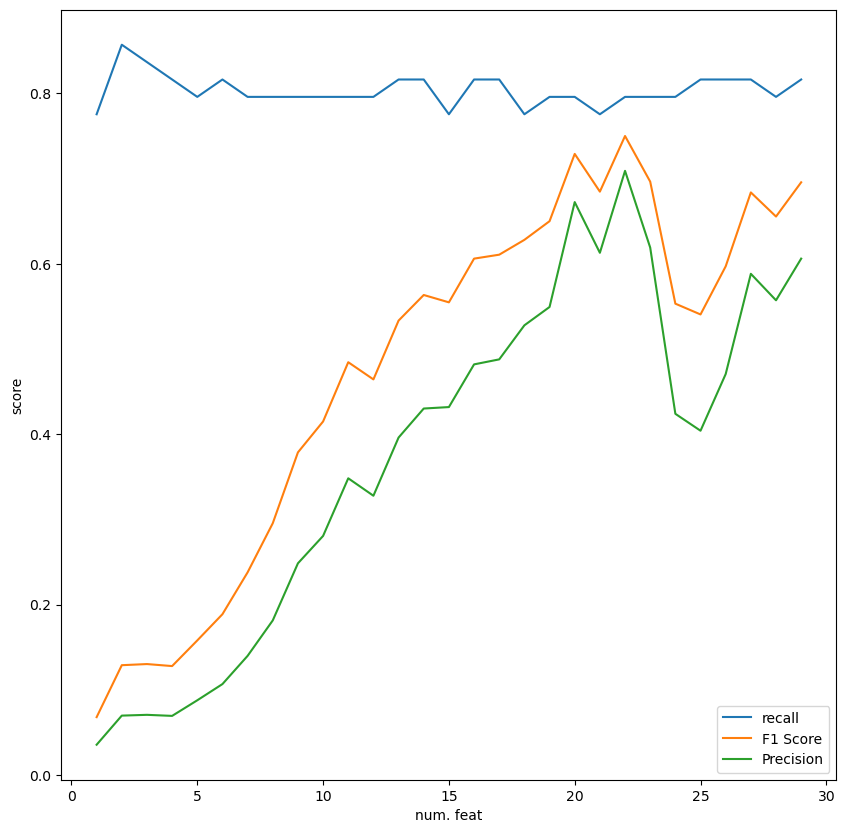

In [322]:
plt.figure(figsize=(10,10))
sns.lineplot(res_corr, x = 'num feature', y = 'Recall', label = 'recall')
sns.lineplot(res_corr, x = 'num feature', y = 'F1 Score', label = 'F1 Score')
sns.lineplot(res_corr, x = 'num feature', y = 'Precision', label = 'Precision')
plt.xlabel('num. feat')
plt.ylabel('score')

In [325]:
res_corr['F1 Score'].max()

0.75

by this technique, turns out using all of the columns produces the highes recall, precision, and f1

## variance

In [323]:
variance = X_train.var().sort_values()


In [324]:
tresh = [0.1,0.2,0.5,0.8,1,2,3]

res_var = pd.DataFrame({'tresh': [],
                       "Precision": [],
                       "Recall": [],
                       "F1 Score": []})
for i in tresh:
    filtered_col = list(variance[variance >= i].index)
    X_train_cor, X_val_cor, X_test_cor = X_smt.copy(), X_val.copy(), X_test.copy()
    X_train_cor = X_train_cor[filtered_col]
    X_val_cor = X_val_cor[filtered_col]
    X_test_cor = X_test_cor[filtered_col]

    print('num_feat:' + str(len(filtered_col)))
    print('tresh:' +str(i) )
    
    print(filtered_col)
    print()
    xgb = XGBClassifier(
        learning_rate = 0.5,
        max_depth =4,
        # n_estimator = 200,
        early_stopping_rounds=10,
        # eval_metric= roc_auc_score,
        random_state = 2908)

    xgb.fit(X_train_cor,y_smt,eval_set=[(X_val_cor,y_val)], verbose= 0
            )
    y_pred = xgb.predict(X_test_cor)

    # Precision: TP/(TP+FP)
    print("Precision:", precision_score(y_test, y_pred))
    # Recall: TP/(TP+FN)
    print("Recall:", recall_score(y_test, y_pred))
    # F1 Score: 2*recall*precision/(recall+precision) ie. balance between precision and recall
    print("F1 Score:", f1_score(y_test, y_pred))
    # print(classification_report(y_test, y_pred, target_names = ['not fraud', 'fraud']))
    # cfs_mat = confusion_matrix(y_test, y_pred)
    # print(cfs_mat)
    print()
    new_row = {'tresh': i,
            'accuracy': accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)}
    res_var.loc[len(res_var)] = new_row

res_var

num_feat:29
tresh:0.1
['V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

Precision: 0.5633802816901409
Recall: 0.8163265306122449
F1 Score: 0.6666666666666666

num_feat:27
tresh:0.2
['V26', 'V25', 'V24', 'V23', 'V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

Precision: 0.5633802816901409
Recall: 0.8163265306122449
F1 Score: 0.6666666666666666

num_feat:23
tresh:0.5
['V22', 'V21', 'V20', 'V19', 'V18', 'V17', 'V16', 'V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

Precision: 0.47619047619047616
Recall: 0.8163265306122449
F1 Score: 0.6015037593984961

num_feat:16
tresh:0.8
['V15', 'V14', 'V13', 'V12', 'V11', 'V10', 'V9', 'V8', 'V7', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1', 'Amount']

P

,tresh,Precision,Recall,F1 Score
0,0.1,0.563380,0.816327,0.666667
1,0.2,0.563380,0.816327,0.666667
2,0.5,0.476190,0.816327,0.601504
3,0.8,0.404040,0.816327,0.540541
4,1.0,0.236686,0.816327,0.366972
5,2.0,0.042599,0.816327,0.080972
6,3.0,0.007705,0.775510,0.015258
